In [2]:
#!pip install torch
#!pip install opencv-python
#!pip install matplotlib
#!pip install numpy
#!pip install tqdm
#!pip install os
#!pip install torchvision
#!pip install kaggle
#!pip install opendatasets
#!pip install opencv-python
#!pip install torch torchvision timm
#!pip install ipywidgets
#!pip install torchsummary

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm.notebook import tqdm
import zipfile
import opendatasets as od
import glob
import random
import matplotlib.pyplot as plt
from torchvision import transforms as T, datasets
from helper import show_image
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid 
from helper import show_grid
import torchvision.datasets as dataset
from skimage.transform import AffineTransform, warp, resize
import cv2 
#from torch.utils.data
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch import nn
import torch.nn.functional as F
import timm
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchsummary import summary
from helper import accuracy 


In [4]:
class CFG:

    epochs = 1 #training model
    lr = 0.001 #learning rate
    batch_size = 16 #batch size for ds
    model_name = 'tf_efficientnet_b6_ns' # model name 
    img_size = 224

    DATA_DIR = "chest_xray_data/chest_xray/chest_xray" 
    TRAIN = "train"
    VAL = "val"
    TEST = "test"
    img_size = 224
     

device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
print("ON WHICH DEVICE WE ARE ON : {}".format(device))

ON WHICH DEVICE WE ARE ON : cpu


In [5]:
#api_token = {"username":"########","key":"######"}

kaggle -setting -create api = kaggle.json => username ve bir key(parola)

Image transformation and load dataset

In [6]:

train_transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.RandomRotation(degrees=(-20, 20)),
    T.ToTensor(),  # (H, W, C) -> (C, H, W)
    T.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),
    T.ToTensor(),  # (H, W, C) -> (C, H, W)
    T.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),
    T.ToTensor(),  # (H, W, C) -> (C, H, W)
    T.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
train_path = os.path.join (CFG.DATA_DIR, CFG.TRAIN)
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)
test_path = os.path. join (CFG.DATA_DIR, CFG. TEST)

trainset = datasets. ImageFolder(train_path,transform = train_transform)
validset = datasets. ImageFolder(valid_path,transform = valid_transform)
testset = datasets. ImageFolder(test_path,transform = test_transform)

In [8]:
if not os.path.isdir(train_path):
    raise FileNotFoundError(f"Training directory not found: {train_path}")
if not os.path.isdir(valid_path):
    raise FileNotFoundError(f"Validation directory not found: {valid_path}")
if not os.path.isdir(test_path):
    raise FileNotFoundError(f"Test directory not found: {test_path}")


In [9]:
print ("Trainset Size : {}". format(len(trainset))) 
print ("Validset Size : {}". format(len(validset)))  
print ("Testset Size : {}". format (len(testset)))

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


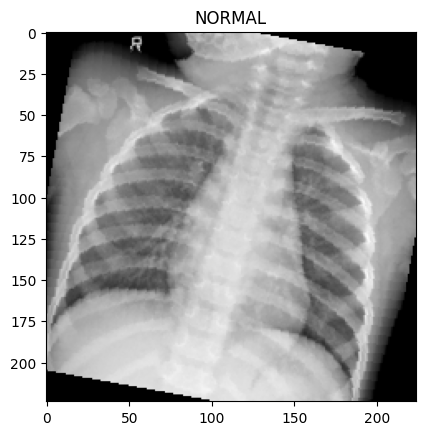

In [39]:
# Sınıf adlarını temsil eden bir liste
class_names = ["NORMAL", "PNEUMONIA"]

# Eğitim veri setinden bir örnek al
image, label = trainset[223]

# Etiketin sınıf adını bul
class_name = class_names[label]

# Görüntüyü göster
show_image(image, class_name)


Load Dataset into Batches

In [11]:
trainloader = DataLoader(trainset, batch_size=CFG.batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=CFG.batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=CFG.batch_size, shuffle=True)

print("No. of batches in trainloader: {}".format(len(trainloader)))
print("No. of Total examples: {}".format(len(trainloader.dataset)))

No. of batches in trainloader: 326
No. of Total examples: 5216


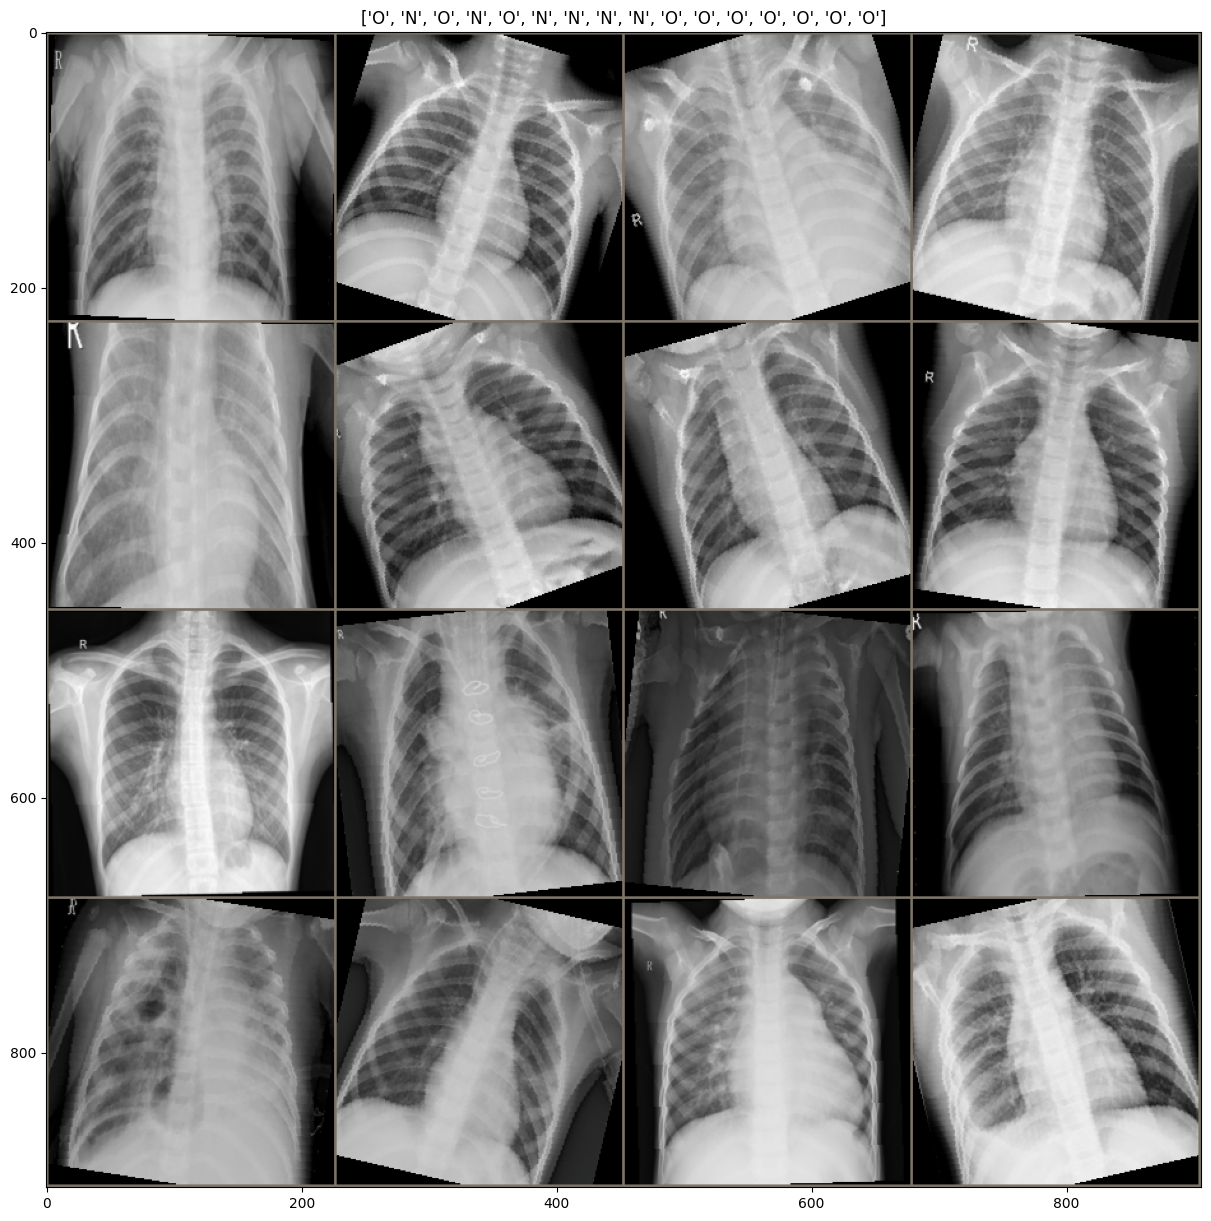

In [12]:
dataiter = iter (trainloader)
images, labels = next(dataiter)
out = make_grid(images,nrow = 4)
show_grid(out, title = [class_name[x] for x in labels])

Fine Tuning EfficientNet Model

In [13]:

model = timm.create_model(CFG.model_name, pretrained=True)

in_features = 2304  

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(

    
    nn. Linear (in_features =in_features , out_features = 625) ,
    nn.ReLU(),
    nn.Dropout (p = 0.3),
    nn.Linear (in_features = 625, out_features = 256) ,
    nn.ReLU(),
    nn.Linear (in_features = 256, out_features = 2)
)
print(model)

/opt/anaconda3/lib/python3.11/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b6_ns to current tf_efficientnet_b6.ns_jft_in1k.
  model = create_fn(


EfficientNet(
  (conv_stem): Conv2dSame(3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    56, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
        (bn1): BatchNormAct2d(
          56, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(56, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          32, ep

In [14]:
dummy_input = torch.randn(1, 3, 224, 224) 

# Pass the dummy input through the model up to the penultimate layer
model.eval()
with torch.no_grad():
    features = model.forward_features(dummy_input)  # This may vary depending on the model's architecture

# Print the shape of the output features
print(features.shape)

torch.Size([1, 2304, 7, 7])


In [15]:
summary (model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 56, 112, 112]           1,512
          Identity-2         [-1, 56, 112, 112]               0
              SiLU-3         [-1, 56, 112, 112]               0
    BatchNormAct2d-4         [-1, 56, 112, 112]             112
            Conv2d-5         [-1, 56, 112, 112]             504
          Identity-6         [-1, 56, 112, 112]               0
              SiLU-7         [-1, 56, 112, 112]               0
    BatchNormAct2d-8         [-1, 56, 112, 112]             112
            Conv2d-9             [-1, 14, 1, 1]             798
             SiLU-10             [-1, 14, 1, 1]               0
           Conv2d-11             [-1, 56, 1, 1]             840
          Sigmoid-12             [-1, 56, 1, 1]               0
    SqueezeExcite-13         [-1, 56, 112, 112]               0
           Conv2d-14         [-1, 32, 1

In [16]:
class PneumoniaTrainer():
    def __init__(self, criterion, optimizer, scheduler):
        self.criterion = criterion # kayiplar 
        self.optimizer = optimizer # update
        self.scheduler = scheduler # optional 

    def train_batch_loop(self, model, trainloader):
        train_acc = 0.0
        train_loss = 0.0
        
        # Eğitim modunda geçiş
        model.train()
        
        for images, labels in tqdm(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = self.criterion(logits, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(logits, labels)
                
        return train_acc / len(trainloader), train_loss / len(trainloader)
        
    def valid_batch_loop(self, model, validloader):
        valid_acc = 0.0
        valid_loss = 0.0
        
        # Değerlendirme modunda geçiş
        model.eval()
        
        with torch.no_grad():
            for images, labels in tqdm(validloader):
                
                images = images.to(device)
                labels = labels.to(device)

                logits = model(images)
                loss = self.criterion(logits, labels)

                valid_loss += loss.item()
                valid_acc += accuracy(logits, labels)
            
        return valid_acc / len(validloader), valid_loss / len(validloader)

    def fit(self, model, trainloader, validloader, epochs):
        model = model.to(device)
        valid_min_loss = np.Inf
        
        for epoch in range(epochs):
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, trainloader)
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, validloader)
            
            # Scheduler (eğer varsa) güncellenir
            if self.scheduler is not None:
                self.scheduler.step(avg_valid_loss)
            
            # En iyi doğrulama kaybını kontrol eder ve modeli kaydeder
            if avg_valid_loss <= valid_min_loss:
                print("Valid loss decreased ({} --> {})".format(valid_min_loss, avg_valid_loss))
                torch.save(model.state_dict(), 'PneumoniaModel.pt')
                valid_min_loss = avg_valid_loss
                
            # Her epoch'un sonunda sonuçları yazdırır
            print("Epoch: {} Train Loss: {:.4f} Train Acc: {:.4f}".format(epoch+1, avg_train_loss, avg_train_acc))
            print("Epoch: {} Valid Loss: {:.4f} Valid Acc: {:.4f}".format(epoch+1, avg_valid_loss, avg_valid_acc))


training model

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)
schedular = None

trainer = PneumoniaTrainer (criterion, optimizer, schedular)
trainer. fit (model, trainloader, validloader, epochs = CFG. epochs)

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss decreased (inf --> 0.4842442572116852)
Epoch: 1 Train Loss: 0.3110 Train Acc: 0.8735
Epoch: 1 Valid Loss: 0.4842 Valid Acc: 0.6875


In [18]:
torch.save(model.state_dict(), 'ColabPneumonia.pt')

In [19]:
from helper import view_classify

model.load_state_dict(torch.load('ColabPneumonia.pt', map_location=device))
model.to(device)
model.eval()

avg_test_acc , avg_test_loss = trainer.valid_batch_loop(model,testloader)

print("Test Acc : {}".format(avg_test_acc))
print("Test Loss : {}".format(avg_test_loss))


  0%|          | 0/39 [00:00<?, ?it/s]

Test Acc : 0.7339743375778198
Test Loss : 0.5068899110341684


In [ ]:
#image, label = testset [324]

#ps = model (image. to (device).unsqueeze (0) )
#ps = F.softmax(ps, dim = 1)

#view_classify (image, ps, label)

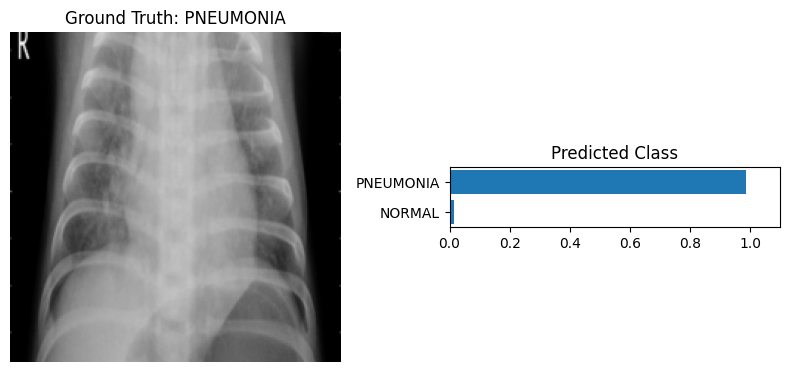

In [50]:
image, label = testset[549]
image = image.unsqueeze(0).to(device)

logit = model(image)
ps = F.softmax(logit, dim=1)

view_classify(image.squeeze().cpu(), ps.cpu(), label)